# Import the datasets

In [103]:
# Let's import that necessary libraries 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from google.colab import files


# Get the Data ready. 
Load it in and create our training and test sets.

In [25]:
# Let's load in the dataset 
data = pd.read_csv("insurance.csv")
# Create the X and y matricies
# The response variable is the last column 
X = data[['age','sex', 'bmi', 'children', 'smoker', 'region']]
# Apply one-hut encoding to our strings
X = pd.get_dummies(X, prefix=['sex', 'smoker', 'region'])
y = data['charges']
# We want to apply a log transformation because the response is log-normally
# distributed
y = np.log(y)
# Create the training and test sets
# Our dataset isn't that large so we will create our test set as 30% of our
# dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, 
                                                    random_state = 101)


In [7]:
# What does our training set look like?
X_train.head(10)

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
405,52,38.380,2,1,0,1,0,1,0,0,0
835,42,35.970,2,0,1,1,0,0,0,1,0
483,51,39.500,1,1,0,1,0,0,0,0,1
319,32,37.335,1,0,1,1,0,1,0,0,0
956,54,30.800,1,0,1,0,1,0,0,1,0
175,63,37.700,0,1,0,0,1,0,0,0,1
636,19,24.510,1,1,0,1,0,0,1,0,0
421,61,35.860,0,0,1,0,1,0,0,1,0
1061,57,27.940,1,0,1,1,0,0,0,1,0
537,46,30.200,2,1,0,1,0,0,0,0,1


In [8]:
print(y_train)

405    11396.90020
835     7160.33030
483     9880.06800
319     4667.60765
956    41999.52000
          ...     
575    12222.89830
973     1759.33800
75     11356.66090
599    33471.97189
863     5458.04645
Name: charges, Length: 936, dtype: float64


# Statistical Analysis
Let's start creating our models
## Linear Regression

In [37]:
# Import the Linear model Libraries
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
# Create a Design Matrix with the training data
X2 = sm.add_constant(X_train)
# Create the instance of the linear model
est = sm.OLS(y_train, X2)
# Fit the model
lm = est.fit()
# Output the summary
print(lm.summary())
# So, what do we see?
# Well first we see that the adjusted R^2 isn't great, so we want this to 
# probably be higher, but it is already pretty close to R^2
# We also see that all of the variables have a p-value of less than 0.05
# (they are quite a bit less), so that means that we have the best model we 
# can from using MLR.
# From the EDA, we saw that none of the variables have polynomial trends with 
# the response, but we did see that BMI and Age did have a large difference 
# when we adjusted for smokers, so for our next model, let's try to add an
# interaction term with those
# We make those models in R

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     359.5
Date:                Thu, 11 Feb 2021   Prob (F-statistic):          5.08e-278
Time:                        03:27:30   Log-Likelihood:                -591.89
No. Observations:                 936   AIC:                             1202.
Df Residuals:                     927   BIC:                             1245.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.4173      0.039  

## KNN Regression

In [37]:
# Let's create a KNN model, we will also tune the Neighbours parameter
# to get the one with the best fit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
# The possible values of our K
n_neighbors = list(range(1,30))
# Possible leaf size
leaf_size = list(range(1,50)) 
# We will leave P at 2
# Create a dictionary for our parameters 
hyperparameters = dict(n_neighbors=n_neighbors, 
                       leaf_size=leaf_size)
knn_tune = KNeighborsRegressor()
# Use GridSearch
clf = GridSearchCV(knn_tune, hyperparameters, cv=10, verbose=3)
# Before we fit the model, we need to remove some of our predictors
# Since this is a distance based algorithm, we can't use Region
# For the other factors, like smoker and sex, we can just set them to
# 1 or 0 (since we only have 2 values) and thats fine but for 
# region we have a lot of possibilities so we can't use that 
# (The algorithm will still work but it doesn't make sense)
# We will also scale the X_train and X_test because this is distance
# based so it makes sense to scale the continuous variables
# Create the training and test design matrix
X_train_knn = X_train.iloc[:, 0:7]
X_test_knn = X_test.iloc[:, 0:7]
# Create our scaler
sc = StandardScaler()
# Scale the age, bmi & children variables
X_train_knn.iloc[:, 0:3] = sc.fit_transform(X_train_knn.iloc[:, 0:3])
X_test_knn.iloc[:, 0:3] = sc.transform(X_test_knn.iloc[:, 0:3])
# Fit the model
best_model = clf.fit(X_train_knn, y_train)

Fitting 10 folds for each of 1421 candidates, totalling 14210 fits
[CV] leaf_size=1, n_neighbors=1 ......................................
[CV] .......... leaf_size=1, n_neighbors=1, score=0.683, total=   0.0s
[CV] leaf_size=1, n_neighbors=1 ......................................
[CV] .......... leaf_size=1, n_neighbors=1, score=0.779, total=   0.0s
[CV] leaf_size=1, n_neighbors=1 ......................................
[CV] .......... leaf_size=1, n_neighbors=1, score=0.400, total=   0.0s
[CV] leaf_size=1, n_neighbors=1 ......................................
[CV] .......... leaf_size=1, n_neighbors=1, score=0.500, total=   0.0s
[CV] leaf_size=1, n_neighbors=1 ......................................
[CV] .......... leaf_size=1, n_neighbors=1, score=0.550, total=   0.0s
[CV] leaf_size=1, n_neighbors=1 ......................................
[CV] .......... leaf_size=1, n_neighbors=1, score=0.512, total=   0.0s
[CV] leaf_size=1, n_neighbors=1 ......................................
[CV] .....

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


Streaming output truncated to the last 5000 lines.
[CV] leaf_size=41, n_neighbors=12 ....................................
[CV] ........ leaf_size=41, n_neighbors=12, score=0.851, total=   0.0s
[CV] leaf_size=41, n_neighbors=12 ....................................
[CV] ........ leaf_size=41, n_neighbors=12, score=0.855, total=   0.0s
[CV] leaf_size=41, n_neighbors=12 ....................................
[CV] ........ leaf_size=41, n_neighbors=12, score=0.815, total=   0.0s
[CV] leaf_size=41, n_neighbors=12 ....................................
[CV] ........ leaf_size=41, n_neighbors=12, score=0.693, total=   0.0s
[CV] leaf_size=41, n_neighbors=12 ....................................
[CV] ........ leaf_size=41, n_neighbors=12, score=0.706, total=   0.0s
[CV] leaf_size=41, n_neighbors=12 ....................................
[CV] ........ leaf_size=41, n_neighbors=12, score=0.767, total=   0.0s
[CV] leaf_size=41, n_neighbors=12 ....................................
[CV] ........ leaf_size=41

[Parallel(n_jobs=1)]: Done 14210 out of 14210 | elapsed:  1.8min finished


In [38]:
# What is the best model?
best_model

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [52]:
# Let's make our final model now
knn_model = KNeighborsRegressor(n_neighbors = 5, metric = 'minkowski',
                                leaf_size = 30)
knn_model.fit(X_train_knn, y_train)
# What is our Training RMSE, Test RMSE and Adjusted R Squared?
from sklearn.metrics import mean_squared_error
knn_training_predictions = knn_model.predict(X_train_knn)
knn_test_predictions = knn_model.predict(X_test_knn)
# Training RMSE 
# We will test the actual scale, not the log scale
np.sqrt(mean_squared_error(np.exp(y_train), np.exp(knn_training_predictions)))

4808.9189612439495

In [53]:
# Test RMSE 
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(knn_test_predictions)))

5648.033266801163

In [72]:
# Adjusted R Squared
n = 936
p = 5
from sklearn.metrics import r2_score
r_squared = r2_score(y_train, knn_training_predictions)
adjusted_r_squared = 1 - ((1-r_squared) * (n - 1))/(n - p - 1)
adjusted_r_squared

0.8396399794216876

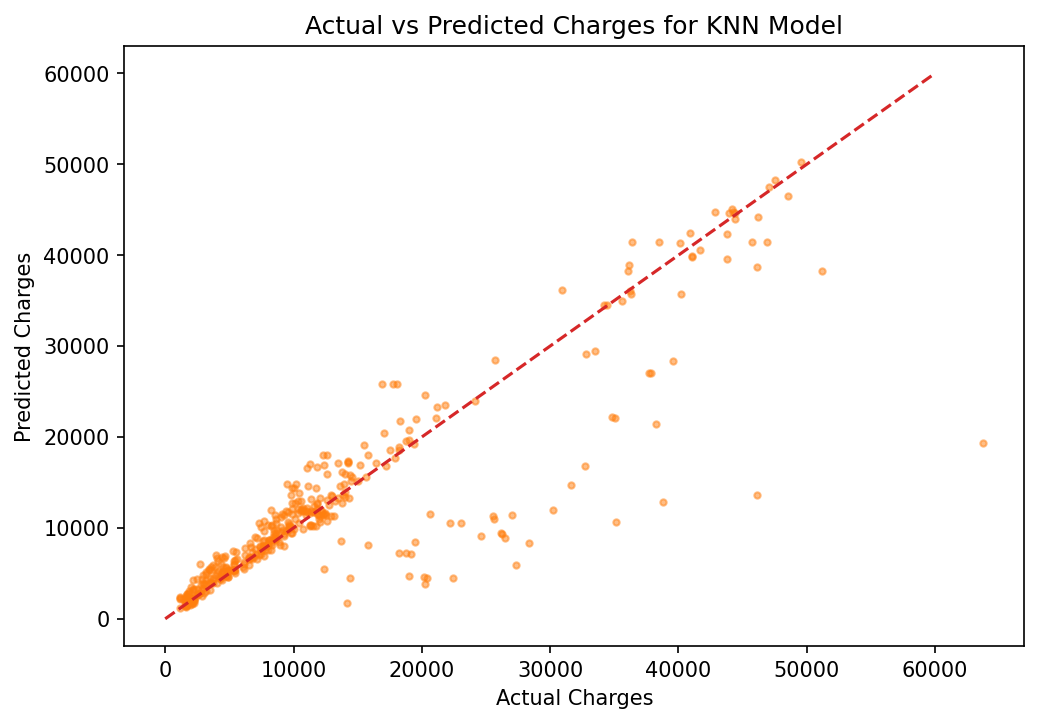

In [75]:
# How do our predictions look?
# For the straigt line
x = np.linspace(0,60000,600000)
y = x
fig = plt.figure(dpi = 150, figsize = (6, 4))
ax = fig.add_axes([0, 0, 1, 1])
ax.scatter(np.exp(y_test), np.exp(knn_test_predictions),
           marker = ".", alpha = 0.5, color = "tab:orange")
ax.plot(x, y, color = "tab:red", ls = "--")
ax.set_xlabel("Actual Charges")
ax.set_ylabel("Predicted Charges")
ax.set_title("Actual vs Predicted Charges for KNN Model")
plt.show()

## Random Forest Regression

In [91]:
# For our RF Regression, we will use 200 trees (we don't need to tune this
# because our dataset isn't too large so needing more than 200 seems highly
# unlikely)
from sklearn.ensemble import RandomForestRegressor
# The parameters we will tune are the following:
max_depth = [10, 20, 30, 40, 50]
min_samples_split = [2, 5, 10, 15, 20]
min_samples_leaf = [1, 2, 3, 5, 10]
n_estimators = [200]
# For random forest we do not need to scale variables and also we can use
# region for a predictor
# Create the dictionary for tuning hyperparameters
hyperparameters = dict(max_depth=max_depth, 
                       min_samples_split=min_samples_split,
                       min_samples_leaf=min_samples_leaf, 
                       n_estimators=n_estimators)
# Create the RF Regressor instance
rf_tune = RandomForestRegressor()
# Grid Search Instance
clf = GridSearchCV(rf_tune, hyperparameters, cv=10, verbose=3)
# Tuning
best_model = clf.fit(X_train, y_train)

Fitting 10 folds for each of 125 candidates, totalling 1250 fits
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, score=0.868, total=   0.6s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, score=0.892, total=   0.6s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, score=0.836, total=   0.6s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, score=0.752, total=   0.7s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, score=0.810, total=   0.6s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, score=0.800, total=   0.6s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, score=0.837, total=   0.6s
[CV] max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, s

[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed: 10.9min finished


In [92]:
# Ok, so whats our best model?
best_model

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_j

In [94]:
# Let's create this model
rf_model = RandomForestRegressor(n_estimators=200, min_samples_leaf=1, 
                                 min_samples_split=2)
# Fit the model
rf_model.fit(X_train, y_train)
# Let's get some metrics (and predictions)
rf_training_predictions = rf_model.predict(X_train)
rf_test_predictions = rf_model.predict(X_test)
# Training RMSE 
# We will test the actual scale, not the log scale 
# (to make it more interpretable)
np.sqrt(mean_squared_error(np.exp(y_train), np.exp(rf_training_predictions)))
# Wow, that is a lot better than our linear model & KNN

2291.1609420056993

In [95]:
# Test MSE
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(rf_test_predictions)))
# Hmm, that's a lot higher than our training MSE (that is expected though)
# It is still a lot lower than than the test MSE of the linear model & knn

4693.497686086107

In [98]:
# Adjusted R Squared
n = 936
p = 6
# R Squared
r_squared = r2_score(y_train, rf_training_predictions)
adjusted_r_squared = 1 - ((1-r_squared) * (n - 1))/(n - p - 1)
adjusted_r_squared
# Wow, that's a really good adjusted R Squared

0.97444593647566

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

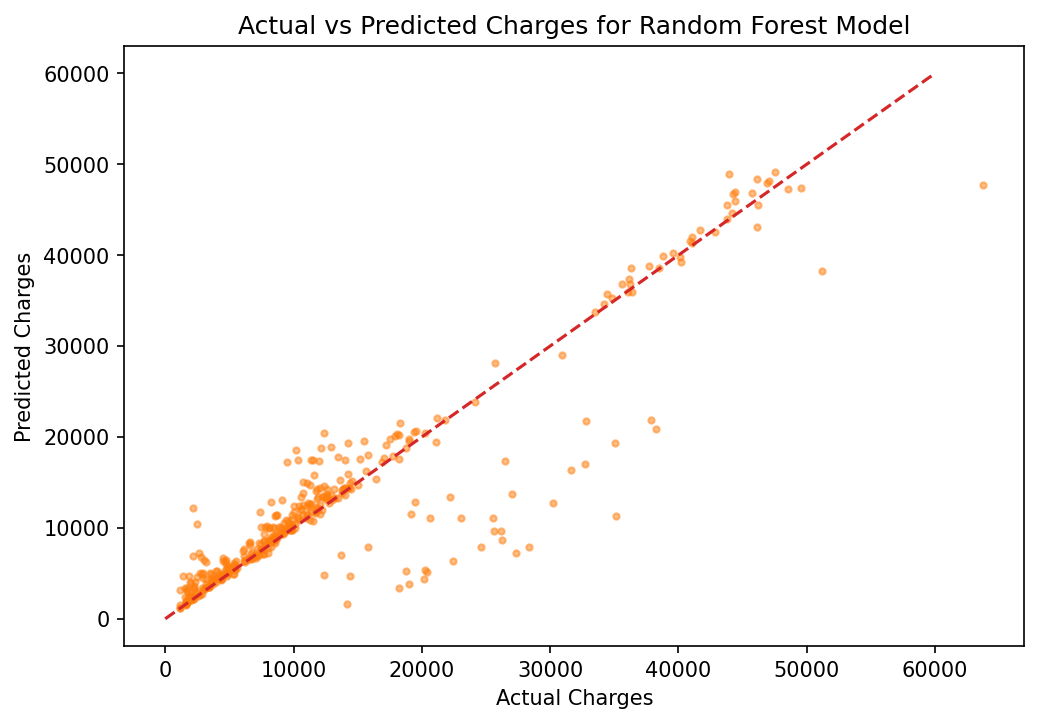

In [105]:
# Let's plot the predictions to see how close they are to the actual values
x = np.linspace(0,60000,600000)
y = x
# Create the plot
fig = plt.figure(dpi = 150, figsize = (6, 4))
ax = fig.add_axes([0, 0, 1, 1])
ax.scatter(np.exp(y_test), np.exp(rf_test_predictions),
           marker = ".", alpha = 0.5, color = "tab:orange")
ax.plot(x, y, color = "tab:red", ls = "--")
ax.set_xlabel("Actual Charges")
ax.set_ylabel("Predicted Charges")
ax.set_title("Actual vs Predicted Charges for Random Forest Model")
fig.show()